## Problem statement: 
#### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
le

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Importing Skin Cancer Data

In [9]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [10]:
# change this data_path to the data set locations 
data_path = "/content/gdrive/My Drive/Colab Notebooks/cnn-dataset"
data_path_train = data_path + '/Train/'
data_path_test = data_path + '/Test/'

In [11]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(data_path_train)
data_dir_test = pathlib.Path(data_path_test)

In [12]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2250
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writting the dataset

# train dataset
train_ds = image_dataset_from_directory(
                        directory=data_dir_train, 
                        labels="inferred", 
                        validation_split=0.2, 
                        subset="training", 
                        color_mode="rgb", 
                        batch_size=batch_size, 
                        image_size=(img_height, img_width), 
                        seed=123)

Found 2250 files belonging to 9 classes.
Using 1800 files for training.


In [15]:
## using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writting the dataset

# validation data set
val_ds = image_dataset_from_directory(
                        directory=data_dir_train, 
                        labels="inferred", 
                        validation_split=0.2, 
                        subset="validation", 
                        color_mode="rgb", 
                        batch_size=batch_size, 
                        image_size=(img_height, img_width), 
                        seed=123)

Found 2250 files belonging to 9 classes.
Using 450 files for validation.


In [16]:
# Test dataset
test_ds = image_dataset_from_directory(
                        directory=data_dir_test, 
                        labels="inferred", 
                        color_mode="rgb", 
                        batch_size=batch_size, 
                        image_size=(img_height, img_width), 
                        seed=123)

Found 118 files belonging to 9 classes.


In [17]:
# Listing out all the classes of skin cancer and storing them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

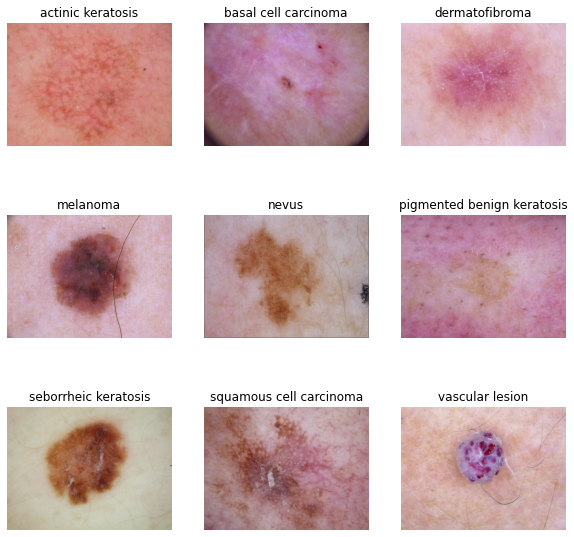

In [18]:
# printing 9 images of 9 classes
plt.figure(figsize=(10, 10))

i = 0
for class_label in class_names:
    imgs = list(data_dir_train.glob(class_label + '/*'))
    
    # reading image as PIL image
    img = PIL.Image.open(str(imgs[0]))
    
    # printing image as plot
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(class_label)
    plt.axis("off")
    i = i+1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here it is good to standardize values to be in the `[0, 1]`

In [20]:
# creating a normalization layer to standardize the RGB channel values from [0,255] to [0,1]
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
# creating model
num_classes = len(class_names)

model = Sequential([
    normalization_layer,
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    
    layers.Dense(num_classes, activation='softmax')
])


### Compile the model
Choosing an optimiser and loss function for model training 

In [22]:
# choosing sgd optimize and Sparse Categorical Cross entropy loss

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Train the model

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 545s 2s/step - loss: 2.0295 - accuracy: 0.2539 - val_loss: 1.8941 - val_accuracy: 0.3178
Epoch 2/20
57/57 [==============================] - 1s 23ms/step - loss: 1.7335 - accuracy: 0.3956 - val_loss: 1.6384 - val_accuracy: 0.4022
Epoch 3/20
57/57 [==============================] - 1s 23ms/step - loss: 1.4933 - accuracy: 0.4844 - val_loss: 1.9691 - val_accuracy: 0.3244
Epoch 4/20
57/57 [==============================] - 1s 23ms/step - loss: 1.3952 - accuracy: 0.5161 - val_loss: 1.5294 - val_accuracy: 0.4511
Epoch 5/20
57/57 [==============================] - 1s 23ms/step - loss: 1.3059 - accuracy: 0.5294 - val_loss: 1.4759 - val_accuracy: 0.4689
Epoch 6/20
57/57 [==============================] - 1s 23ms/step - loss: 1.2411 - accuracy: 0.5550 - val_loss: 1.4338 - val_accuracy: 0.4889
Epoch 7/20
57/57 [==============================] - 1s 23ms/step - loss: 1.1419 - accuracy: 0.5872 - val_loss: 1.4533 - val_accuracy: 0.4933
Epoch 8/20
57

In [24]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0

### Visualizing training results

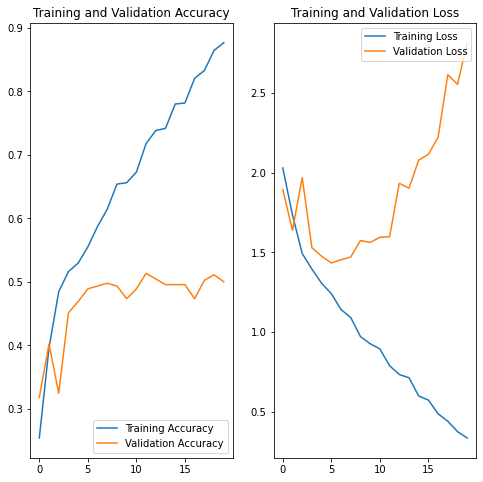

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### My findings

Built a basic model with 3 conv layers and the above graphs clearly shows that the model is overfit as the trianing accuracy is at ~=85% and validation accuracy is at ~=50% which is a clear indication of overfit.

Also, the validation loss is increasing for each epoch which is not the expectation.

We need to improve accuracy and one way is to use dropouts.

In [26]:
# Since the model is overfitting, we have to choose an appropriate data augumentation strategy. 

# craeting a data augmentation layer with random flip and random rotation and random contrast
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomContrast(0.5),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

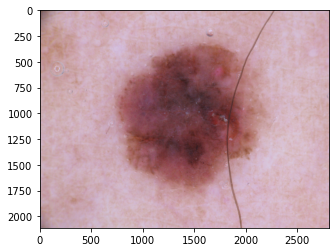

In [27]:
# getting one image from data dir
images = list(data_dir_train.glob('melanoma' + '/*'))
image = PIL.Image.open(str(images[0]))

plt.imshow(image)
plt.show()

In [28]:
# Add the image to a batch as data_augmentation only takes batchs
image = np.array(image)
image = tf.expand_dims(image, 0)

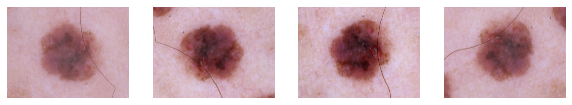

In [29]:
# visualizing how augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for i in range(4):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

### Now Creating the model with augmented data, compile and train the model


In [30]:
# creating model with augmentation layers and some drop outs to increase model accuracy
num_classes = len(class_names)

model = Sequential([
    normalization_layer,
    data_augmentation,
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    
    layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [33]:
# choosing the same adam optimize and Sparse Categorical Cross entropy loss

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [34]:
## training the model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 2s 31ms/step - loss: 1.3161 - accuracy: 0.5239 - val_loss: 1.4586 - val_accuracy: 0.4756
Epoch 2/20
57/57 [==============================] - 2s 28ms/step - loss: 1.2881 - accuracy: 0.5261 - val_loss: 1.4472 - val_accuracy: 0.4689
Epoch 3/20
57/57 [==============================] - 2s 28ms/step - loss: 1.2642 - accuracy: 0.5472 - val_loss: 1.4066 - val_accuracy: 0.4956
Epoch 4/20
57/57 [==============================] - 2s 28ms/step - loss: 1.2962 - accuracy: 0.5294 - val_loss: 1.4052 - val_accuracy: 0.4933
Epoch 5/20
57/57 [==============================] - 2s 28ms/step - loss: 1.2354 - accuracy: 0.5439 - val_loss: 1.4849 - val_accuracy: 0.4778
Epoch 6/20
57/57 [==============================] - 2s 28ms/step - loss: 1.2645 - accuracy: 0.5456 - val_loss: 1.3954 - val_accuracy: 0.5000
Epoch 7/20
57/57 [==============================] - 2s 28ms/step - loss: 1.2149 - accuracy: 0.5711 - val_loss: 1.3986 - val_accuracy: 0.5000
Epoch 8/20
57

### Visualizing the results

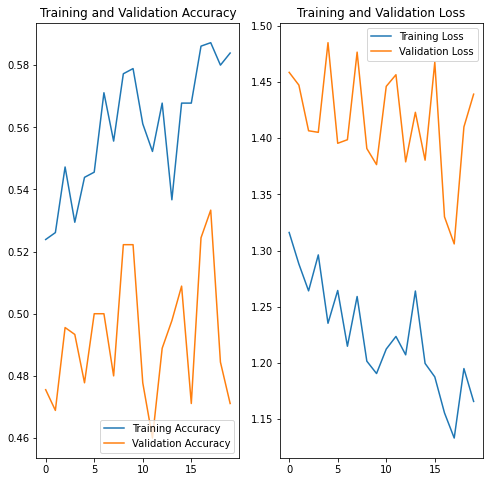

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After updating the model with data augmentation and dropouts, we can clearly see the overfitting is now gone even though the accuracy of train and validation is ~= 55% and the loss is ~=1.2%

#### Distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [36]:
# listing the imange count of each class to see if there is any class imbalances

total = len(list(data_dir_train.glob('*/*.jpg')))
print(total)
for class_label in class_names:
    imgs = list(data_dir_train.glob(class_label + '/*.jpg'))
    
    count = len(imgs)
    print('class: ', class_label)
    print('    count: ', count, ' percentage: ', count/total*100)

2250
class:  actinic keratosis
    count:  114  percentage:  5.066666666666666
class:  basal cell carcinoma
    count:  378  percentage:  16.8
class:  dermatofibroma
    count:  95  percentage:  4.222222222222222
class:  melanoma
    count:  438  percentage:  19.466666666666665
class:  nevus
    count:  357  percentage:  15.866666666666667
class:  pigmented benign keratosis
    count:  471  percentage:  20.933333333333334
class:  seborrheic keratosis
    count:  77  percentage:  3.4222222222222225
class:  squamous cell carcinoma
    count:  181  percentage:  8.044444444444444
class:  vascular lesion
    count:  139  percentage:  6.177777777777778


### We can clearly see there is a huge class imbalance

#### - Which class has the least number of samples?

#### **seborrheic keratosis**

#### - Which classes dominate the data in terms proportionate number of samples?

#### **pigmented benign keratosis**


### Rectify the class imbalance
#### **Context:** Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
!pip install Augmentor

In [39]:
path_to_training_dataset = data_path_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/cnn-dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F4153F10>: 100%|██████████| 500/500 [00:18<00:00, 26.77 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 378 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/cnn-dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F018DC50>: 100%|██████████| 500/500 [00:19<00:00, 25.27 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/cnn-dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F41A26D0>: 100%|██████████| 500/500 [00:18<00:00, 27.04 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/cnn-dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF7F4057150>: 100%|██████████| 500/500 [01:28<00:00,  5.66 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/cnn-dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FF7F4057910>: 100%|██████████| 500/500 [01:25<00:00,  5.88 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 471 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/cnn-dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F402BED0>: 100%|██████████| 500/500 [00:19<00:00, 26.14 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/cnn-dataset/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FF7F0196E90>: 100%|██████████| 500/500 [00:42<00:00, 11.79 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/cnn-dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF80819C690>: 100%|██████████| 500/500 [00:19<00:00, 26.31 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/cnn-dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF7F42C3510>: 100%|██████████| 500/500 [00:19<00:00, 25.01 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [52]:
total = len(list(data_dir_train.glob('*/output/*.jpg')))
print(total)
for class_label in class_names:
    imgs = list(data_dir_train.glob(class_label + '/output/*.jpg'))
    
    count = len(imgs)
    print('class: ', class_label)
    print('    count: ', count, ' percentage: ', count/total*100)

4500
class:  actinic keratosis
    count:  500  percentage:  11.11111111111111
class:  basal cell carcinoma
    count:  500  percentage:  11.11111111111111
class:  dermatofibroma
    count:  500  percentage:  11.11111111111111
class:  melanoma
    count:  500  percentage:  11.11111111111111
class:  nevus
    count:  500  percentage:  11.11111111111111
class:  pigmented benign keratosis
    count:  500  percentage:  11.11111111111111
class:  seborrheic keratosis
    count:  500  percentage:  11.11111111111111
class:  squamous cell carcinoma
    count:  500  percentage:  11.11111111111111
class:  vascular lesion
    count:  500  percentage:  11.11111111111111


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [54]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating new training dataset

In [55]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                        directory=data_dir_train, 
                        labels="inferred", 
                        validation_split=0.2, 
                        subset="training", 
                        color_mode="rgb", 
                        batch_size=batch_size, 
                        image_size=(img_height, img_width), 
                        seed=123)

Found 6750 files belonging to 9 classes.
Using 5400 files for training.


#### Creating new validation dataset

In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                        directory=data_dir_train, 
                        labels="inferred", 
                        validation_split=0.2, 
                        subset="validation", 
                        color_mode="rgb", 
                        batch_size=batch_size, 
                        image_size=(img_height, img_width), 
                        seed=123)

Found 6750 files belonging to 9 classes.
Using 1350 files for validation.


####  Creating  model

In [57]:
model = Sequential([
    normalization_layer,
    data_augmentation,
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    
    layers.Dense(num_classes, activation='softmax')
])

#### Compiling the model (Choosing same optimizer and loss function)

In [58]:
# choosing the same adam optimize and Sparse Categorical Cross entropy loss

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Training the model

In [59]:
# using 50 epochs
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 34s 189ms/step - loss: 2.1302 - accuracy: 0.1783 - val_loss: 1.8553 - val_accuracy: 0.3193
Epoch 2/50
169/169 [==============================] - 32s 185ms/step - loss: 1.6412 - accuracy: 0.3772 - val_loss: 1.5647 - val_accuracy: 0.4170
Epoch 3/50
169/169 [==============================] - 33s 191ms/step - loss: 1.5589 - accuracy: 0.4106 - val_loss: 1.5050 - val_accuracy: 0.4311
Epoch 4/50
169/169 [==============================] - 33s 191ms/step - loss: 1.4681 - accuracy: 0.4343 - val_loss: 1.4626 - val_accuracy: 0.4430
Epoch 5/50
169/169 [==============================] - 32s 186ms/step - loss: 1.4159 - accuracy: 0.4491 - val_loss: 1.3911 - val_accuracy: 0.4926
Epoch 6/50
169/169 [==============================] - 32s 185ms/step - loss: 1.3838 - accuracy: 0.4680 - val_loss: 1.4450 - val_accuracy: 0.4430
Epoch 7/50
169/169 [==============================] - 33s 191ms/step - loss: 1.3800 - accuracy: 0.4687 - val_loss: 1.3310 - val_ac

#### Visualize the model results

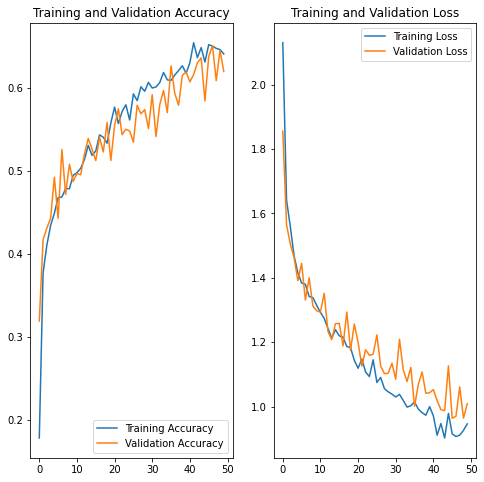

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing results: ***Did you get rid of underfitting/overfitting? Did class rebalance help?***

#### The model shows around ~= 64% accuracy after using 50 epochs. And the loss % is ~= 1%. This model is not overfitted or under fitted as the train and validation accuracies are close to each other. 

#### Over all this model has 64% prediction rate and with loss of 1%

#### **yes**, I got rid of overfitting/underfitting with the dropouts and augmentation. Class rebalancing also helped with improving the model accuracy.
